In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb #extra, just to visualize the multi-class confusion matrix

from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import time           # to get training time
from datetime import timedelta
import joblib         # to save our trained model

## Evaluating different Hyperparameter Tuning Techniques on MNIST using SVMs and NNs

The main goal in this notebook is to show-case several different hyperparemeter tuning techniques. 

Because we will train many times the same model using diferent hyperparameters, we will choose SMV as one of the simplest models able to recognize image patters. The idea is to use a model very simple and that hopefully will require very few training time at each tuning step. 

We select as image dataset the Modified National Institute of Standards and Technology (MNIST) Dataset. The reason is the same reason as before, we require very simple images which will use very few computational resources and thus will facilitate each training step. 

### 1. Data Preparation

#### **0. Get the Data**

**Download the data from [Kaggle](https://www.kaggle.com/oddrationale/mnist-in-csv)**

The original MNIST dataset is in a format that is difficult for beginners to use. This dataset uses the work of [Joseph Redmon](https://pjreddie.com/) to provide the [MNIST dataset in a CSV format](https://pjreddie.com/projects/mnist-in-csv/).

The dataset consists of two files:

- ./data/mnist_train.csv
- ./data/mnist_test.csv

Every row corresponds in these csv files to a handwritten digit. The first column is named `label`, which is the true digit that was written ($0-9$).

For more information on this dataset, please see the [official page](http://yann.lecun.com/exdb/mnist/), which includes:
- "The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image."

Moreover, there are $28 \times 28$ predictors in the dataset. To understsand their meaning, we refer to the same page again:
- "The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field."

#### **1: Data Load**

Let's load the training and test sets as Pandas dataframes:

In [2]:
train = pd.read_csv('./data/mnist_train.csv')
test = pd.read_csv('./data/mnist_test.csv')

In [3]:
print("Training set shape:", train.shape, "test set shape:", test.shape) # 28x28 = 784 features + 1 label = 785 colums

Training set shape: (60000, 785) test set shape: (10000, 785)


In [4]:
train.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **2: Data Inspection**

We will plot (with a histogram) the distribution of the digits in the training set. At the same time, we report if there are missing values (if yes, drop such rows).

**Train dataset:**

In [6]:
train['label'].value_counts(dropna=False, normalize=True)

1    0.112367
7    0.104417
3    0.102183
2    0.099300
9    0.099150
0    0.098717
6    0.098633
8    0.097517
4    0.097367
5    0.090350
Name: label, dtype: float64

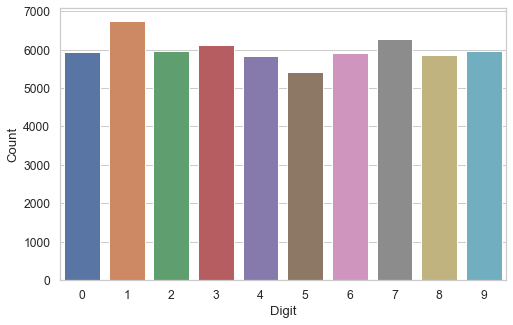

In [7]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=train['label']).set(xlabel='Digit', ylabel='Count');

As we can see, there is no missing values in the train dataset. Label categories are balanced.

**Test dataset:**

In [8]:
test['label'].value_counts(dropna=False, normalize=True) # --> No missing values. Label categories are balanced.

1    0.1135
2    0.1032
7    0.1028
3    0.1010
9    0.1009
4    0.0982
0    0.0980
8    0.0974
6    0.0958
5    0.0892
Name: label, dtype: float64

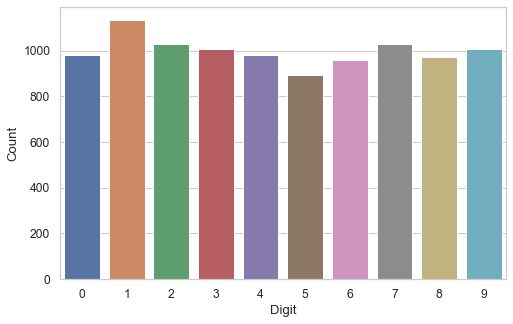

In [9]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=test['label']).set(xlabel='Digit', ylabel='Count');

And the same for the test dataset, there is no missing values here. Label categories are again almost balanced.

**Train dataset images visualization:**

Visualize whichever row you like below. Just change the `instance` variable value, between 0 and 59_999.

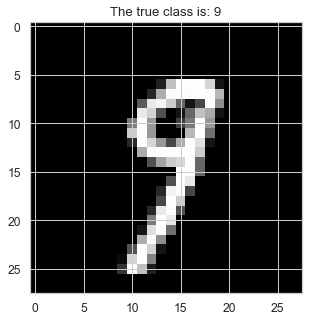

In [10]:
instance = 43 #change this freely to see different visualizations

plt.imshow(np.reshape(np.array(train.iloc[instance,1:]), (-1,28)), cmap = 'gray');

plt.title('The true class is: %i' %train.iloc[instance, 0])
plt.show()

#### **3: Data Preparation**

##### **3.1 Random Undersampling:**

Let's undersample train data a bit : it will take too much time to train the whole dataset in any regular laptop.

**Train dataset:**

In [11]:
# random sampling:

new_traindata_size = 5000

index_filter = list(train.sample(n=new_traindata_size, random_state=1).index)

train_undersampled_1 = train.filter(items=index_filter, axis='index')
print(train_undersampled_1.shape)

(5000, 785)


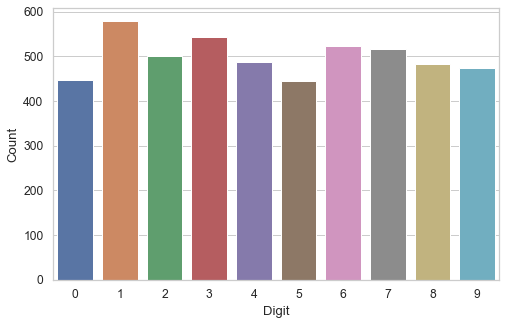

In [12]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=train_undersampled_1['label']).set(xlabel='Digit', ylabel='Count');

**Test dataset:**

In [13]:
# random sampling:

new_testdata_size = round(new_traindata_size/6)

index_filter = test.sample(n=new_testdata_size).index
#print(len(index_filter))

test_undersampled_1 = test.filter(items=index_filter, axis='index')
test_undersampled_1.shape

(833, 785)

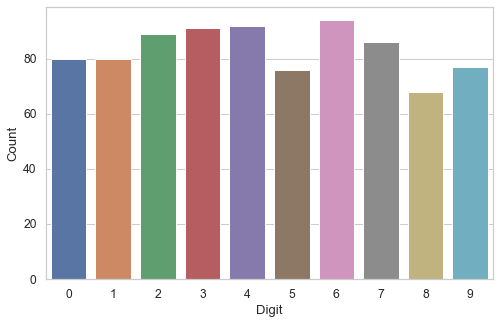

In [14]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=test_undersampled_1['label']).set(xlabel='Digit', ylabel='Count');

Because the size of the final test set is small, we get a slightly unbalanced set after undersampling. Let's perform an stratified random sampling instead.

##### **3.2 Stratified Random Undersampling:**

**Train dataset:**

In [15]:
from sklearn.utils import shuffle

# test data stratified undersampling:

new_class_strata_train_size = 500

train_undersampled_2 = shuffle(train.groupby('label', group_keys=False).apply(lambda x: x.sample(new_class_strata_train_size))) # randomly sample 100 examples from each label group
train_undersampled_2.reset_index(inplace=True,drop=True)
print(train_undersampled_2.shape)
train_undersampled_2.head()

(5000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_undersampled_2['label'].value_counts(dropna=False)

8    500
2    500
4    500
3    500
9    500
6    500
7    500
5    500
1    500
0    500
Name: label, dtype: int64

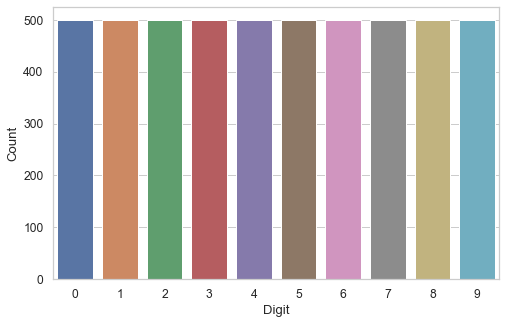

In [17]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=train_undersampled_2['label']).set(xlabel='Digit', ylabel='Count');

**Test dataset:**

In [18]:
# test data stratified undersampling:

new_class_strata_test_size = round(new_class_strata_train_size) #

test_undersampled_2 = shuffle(test.groupby('label', group_keys=False).apply(lambda x: x.sample(new_class_strata_test_size))) # randomly sample 100 examples from each label group
test_undersampled_2.reset_index(inplace=True,drop=True)
print(test_undersampled_2.shape)
test_undersampled_2.head()

(5000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_undersampled_2['label'].value_counts()

9    500
0    500
7    500
3    500
5    500
6    500
2    500
4    500
8    500
1    500
Name: label, dtype: int64

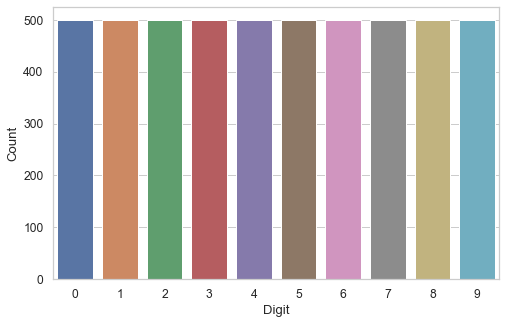

In [20]:
sb.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sb.countplot(x=test_undersampled_2['label']).set(xlabel='Digit', ylabel='Count');

##### **3.3 Image Data Standardization: MinMaxScaler**

In [21]:
#from sklearn.model_selection import train_test_split
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.80, random_state=42)

X_train = train_undersampled_2.iloc[:,1:]   #predictors of the training set
y_train = train_undersampled_2.iloc[:,0]    #targets (true digits) of the training set

print(X_train.shape)
print(y_train.shape)

(5000, 784)
(5000,)


In [22]:
X_test = test_undersampled_2.iloc[:,1:]     #predictors of the test set
y_test = test_undersampled_2.iloc[:,0]      #targets (true digits) of the test set

print(X_test.shape)
print(y_test)

(5000, 784)
0       9
1       0
2       7
3       3
4       5
       ..
4995    7
4996    5
4997    7
4998    4
4999    9
Name: label, Length: 5000, dtype: int64


In [23]:
# First standardize every x_i: only standardize the predictors. Keep the code below.

from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)

X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

### 2. SVM Model Training using two different Kernels.

#### **2.1: Training a linear Kernel SVM based classifier (linear SVC). Training time: ~ 8-10 secs**

Let's train a linear Kernel SVM based classifier (linear SVC) on the undersampled training set and after standardizing the data appropriately.

In [24]:
from datetime import timedelta

lin_clf = svm.LinearSVC(max_iter=1_000_000, verbose=True)   # runs the one-versus-rest approach in multi-class classification by default
                                                            # C=1 by default too
                                                            # see: https://scikit-learn.org/stable/modules/svm.html#multi-class-classification for more details                                          
                                                            # max_iter=1_000 by default. Increase it to avoid warning: "liblinear failed to converge, increase the number of iterations."
                                                            # see: https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati

start = time.time()         
         
lin_clf.fit(X_train, y_train)                               # fit the lin_clf to the training set

stop = time.time()                                                                 # stop in secs, 

print(f"\nTraining time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format
print(f"Convergence after: {lin_clf.n_iter_} iterations")

# save the model to disk
filename = './models/LinearSVC_fitted_with_MNIST_undersampled.joblib'
joblib.dump(lin_clf, filename)
print(f"Trained model saved!")

#[LibLinear]
#Training time (hh:mm:ss): 0:00:08
#Convergence after: 4042 iterations                         # USING 5_000 EXAMPLES. 
                                                            # THIS TRAINING IN THE ORIGINAL DATASET (60_000 EXAMPLES) 
                                                            # AND WITH max_iter=5000 WAS ABOUT 15-20 MINS, AND DID NOT CONVERGED 
#Trained model saved!

[LibLinear]
Training time (hh:mm:ss): 0:00:08
Convergence after: 4042 iterations
Trained model saved!


#### **2.2: Linear Kernel SVM classifier evaluation**

##### **2.2.1: Training Confusion Matrix. Training Accuracy: ~99%**

Let's  plot the confusion matrix obtained in the training set and report the accuracy.

In [25]:
filename = './models/LinearSVC_fitted_with_MNIST_undersampled.joblib'
lin_clf = joblib.load(filename)

In [26]:
# pred ... # predict the training set
y_train_pred = lin_clf.predict(X_train)   

In [27]:
#cm = confusion_matrix...
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[500,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1, 490,   0,   0,   0,   0,   0,   8,   1],
       [  0,   0,   1, 490,   0,   2,   0,   1,   3,   3],
       [  0,   1,   0,   1, 497,   0,   0,   0,   0,   1],
       [  0,   0,   0,   3,   2, 487,   2,   0,   4,   2],
       [  0,   0,   0,   0,   0,   1, 499,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500,   0,   0],
       [  1,   0,   2,   2,   0,   6,   2,   1, 484,   2],
       [  1,   1,   0,   4,   4,   2,   0,   0,   3, 485]], dtype=int64)

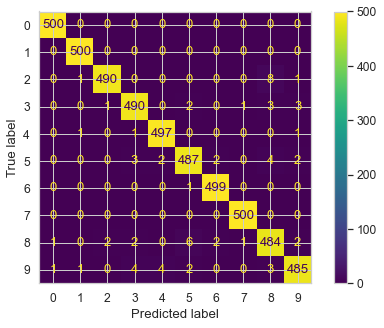

In [28]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train))
cmd.plot();

In [29]:
#accuracy_score ... #use the "sklearn.metric.accuracy_score" to return this (other options are also fine)
print(f'train set accuracy_score = {accuracy_score(y_train, y_train_pred)}')

# train set accuracy_score = 0.9864 # Overfitting??

train set accuracy_score = 0.9864


##### **2.2.2:  Test Confusion Matrix. Test Accuracy: ~87%**

And let's plot now the confusion matrix obtained in the test set and report the accuracy:

In [30]:
# pred = #predict the test set
y_test_linear_pred = lin_clf.predict(X_test)  

In [31]:
#cm = confusion_matrix...
cm = confusion_matrix(y_test, y_test_linear_pred)
cm

array([[474,   0,   0,   3,   0,   8,  10,   4,   1,   0],
       [  1, 474,   4,   3,   0,   1,   4,   0,  13,   0],
       [  5,   4, 418,  17,   2,   7,  13,   8,  22,   4],
       [  3,   2,  18, 429,   1,  20,   1,   5,  17,   4],
       [  0,   0,   7,   4, 435,   4,   5,   1,   6,  38],
       [  8,   4,   4,  26,   7, 407,  18,   7,  15,   4],
       [  8,   1,  14,   0,  11,  15, 447,   0,   2,   2],
       [  2,   5,  10,   5,   7,   4,   0, 437,   1,  29],
       [  7,   9,   7,   8,   8,  19,  11,   3, 413,  15],
       [  5,   2,   4,   3,  18,   8,   3,  15,  10, 432]], dtype=int64)

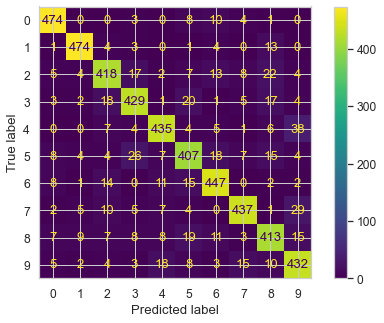

In [32]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [33]:
# accuracy_score ... #use the "sklearn.metric.accuracy_score" to return this (other options are also fine)
print(f'--> LinearSVM: test set accuracy_score = {round(accuracy_score(y_test, y_test_linear_pred),4)}')

# --> LinearSVM: test set accuracy_score = 0.8732

--> LinearSVM: test set accuracy_score = 0.8732


##### **2.2.3: Visualize some classification examples**

Let's take the first 50 images in the test set and see what happened:

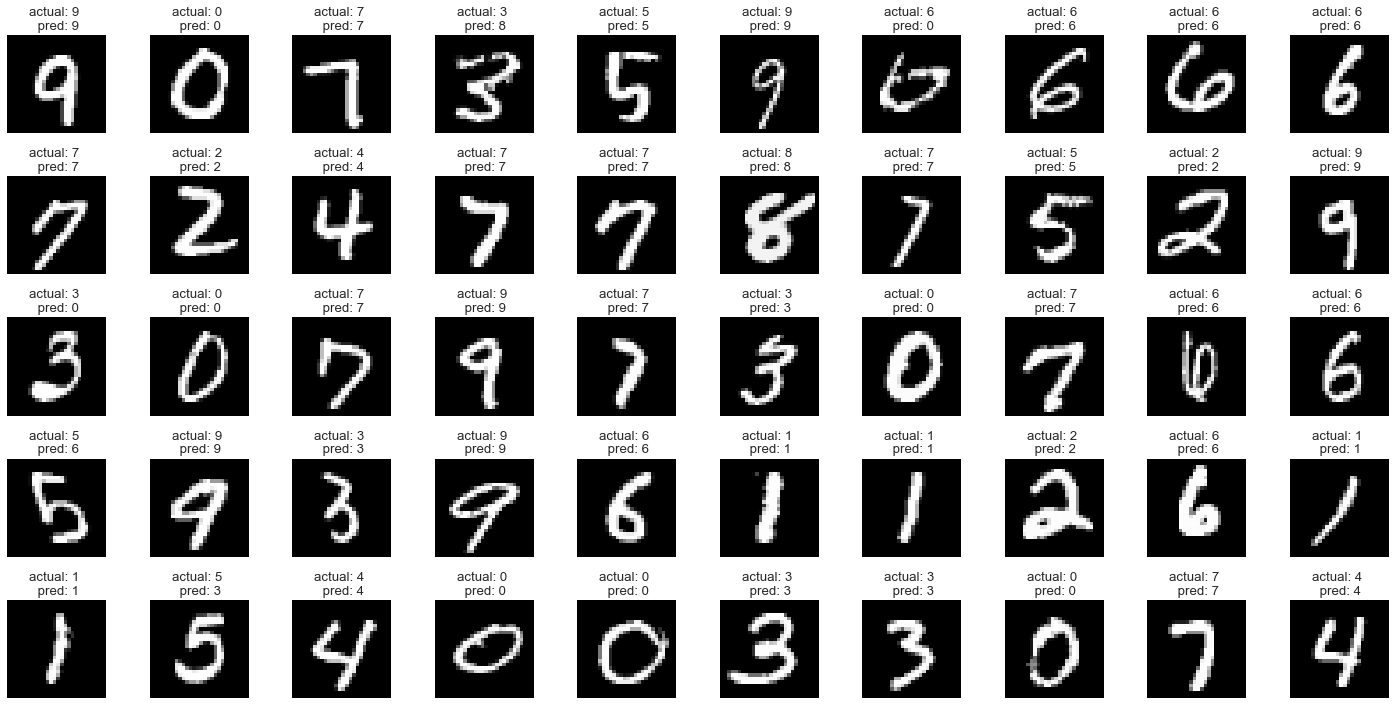

In [34]:
num = 50             

images = X_test[:num]
labels = y_test[:num]
preds = y_test_linear_pred[:num]

test_images_to_plot = []
for i in range(num):
    test_images_to_plot.append(np.reshape(np.array(images[i]), (-1,28)))

num_col = 10
num_row = (len(images) // num_col) if (len(images) % num_col)==0 else (len(images) // num_col) + 1

fig, axs = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
axs = axs.flatten()

for img, label, pred, ax in zip(test_images_to_plot, labels, preds, axs):
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    ax.set_title(f'label: {label}')
    ax.set_title(f'actual: {label} \n pred: {pred}')

plt.tight_layout()
plt.show()

Let's visualize one test digit which we correctly classified:

(28, 28)


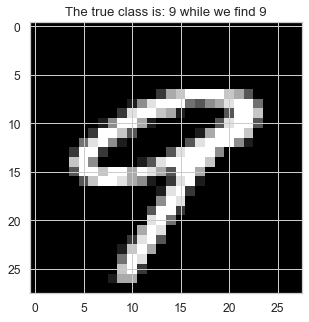

In [35]:
instance = 7  # correct classification 
test_image_to_plot = np.reshape(np.array(X_test[instance]), (-1,28))

print(test_image_to_plot.shape)
plt.imshow(test_image_to_plot, cmap = 'gray');

plt.title('The true class is: %i while we find %i' % (y_test[instance], y_test_linear_pred[instance]))
plt.show()

And now, another one we misclassified:

(28, 28)


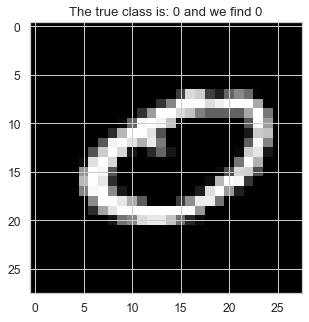

In [36]:
instance = 6  # wrong classification
test_image_to_plot = np.reshape(np.array(X_test[instance]), (-1,28))

print(test_image_to_plot.shape)
plt.imshow(test_image_to_plot, cmap = 'gray');

plt.title(f'The true class is: {y_test[instance]} and we find {y_test_linear_pred[instance]}')
plt.show()

##### **2.2.4: Find misclassification examples.**

Let's for example find a test digit that is originally 4, but we predicted as 3:

In [37]:
#very simple and non-efficient way of finding the index that satisfies this
for i in range(len(y_test)):
    if y_test[i] == 4 and y_test_linear_pred[i] == 3:
        print(i)

251
802
3084
3721


But we can find easily other wrong classfications:

In [38]:
wrong_classifications_for_4_indexes = []

#very simple and non-efficient way of finding wrong classifications for 5:
for i in range(len(y_test)):
    if y_test[i] == 4 and y_test_linear_pred[i] != 4:
        wrong_classifications_for_4_indexes.append(i)

print(wrong_classifications_for_4_indexes)

[75, 83, 180, 192, 251, 438, 485, 503, 584, 802, 844, 925, 1013, 1042, 1236, 1258, 1373, 1421, 1438, 1477, 1689, 1720, 1827, 1900, 1954, 2048, 2094, 2235, 2314, 2326, 2342, 2526, 2604, 2648, 2699, 2747, 2763, 2869, 3041, 3073, 3084, 3087, 3126, 3155, 3233, 3269, 3284, 3313, 3430, 3498, 3564, 3621, 3680, 3721, 3740, 3792, 4143, 4273, 4535, 4685, 4829, 4853, 4876, 4930, 4972]


In [39]:
labels = y_test[wrong_classifications_for_4_indexes].values
labels

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int64)

In [40]:
preds = y_test_linear_pred[wrong_classifications_for_4_indexes]
preds

array([9, 2, 9, 9, 3, 2, 8, 9, 2, 3, 8, 9, 8, 9, 9, 9, 9, 9, 9, 8, 2, 9,
       9, 9, 9, 9, 9, 2, 9, 9, 5, 5, 9, 6, 9, 5, 9, 6, 9, 8, 3, 2, 9, 9,
       6, 9, 9, 9, 6, 9, 9, 9, 9, 3, 7, 9, 6, 9, 9, 9, 2, 9, 8, 5, 9],
      dtype=int64)

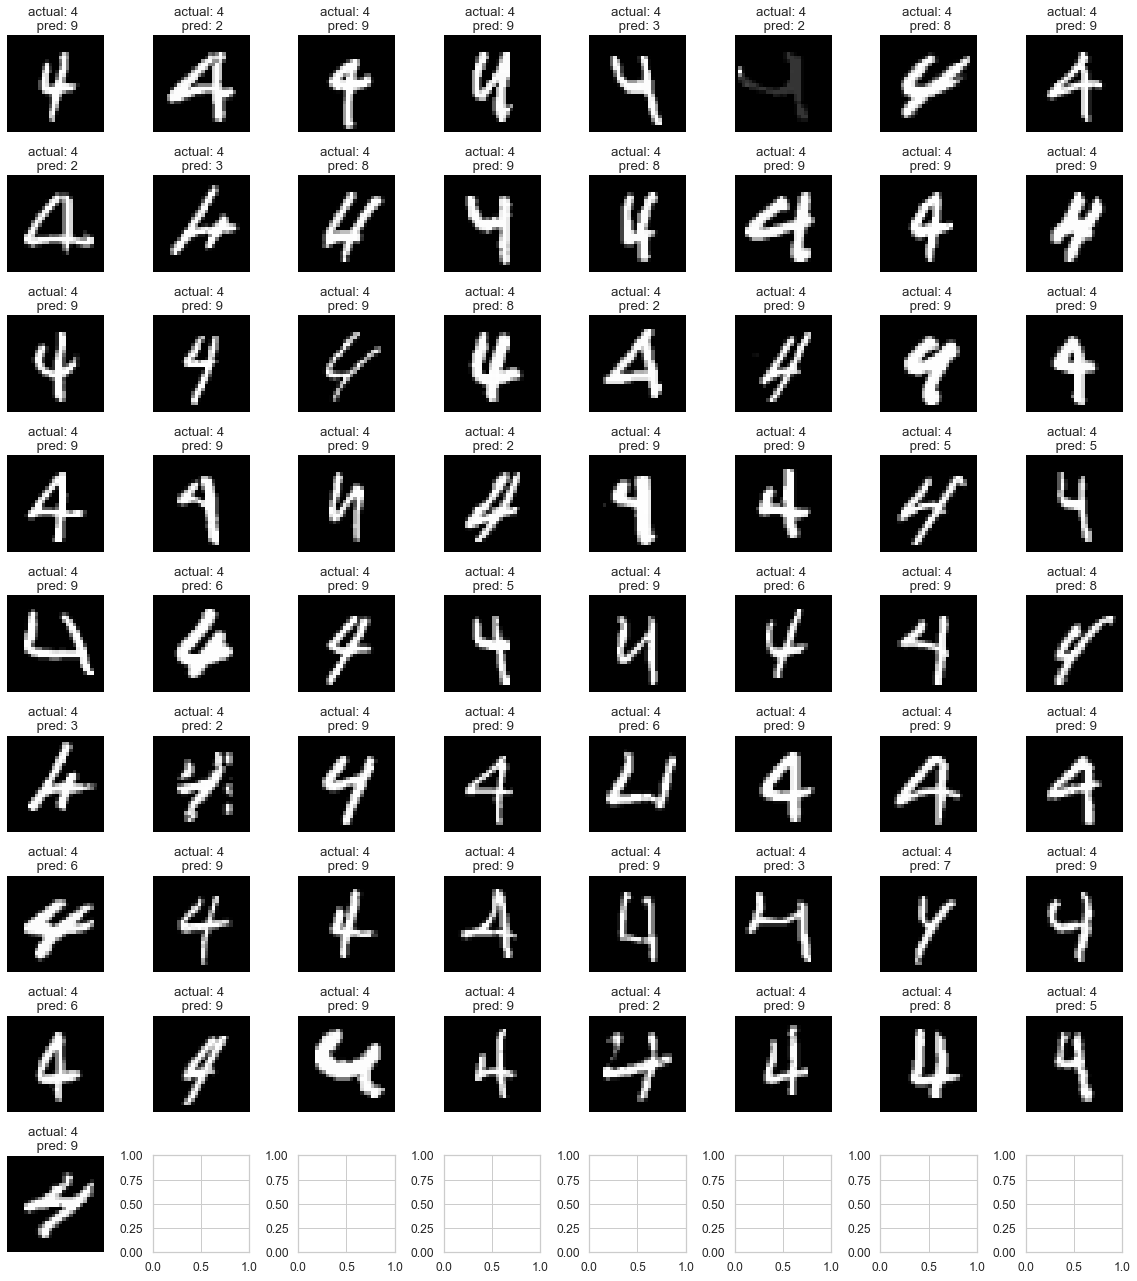

In [41]:
num = len(wrong_classifications_for_4_indexes)
images = X_test[wrong_classifications_for_4_indexes]
labels = y_test[wrong_classifications_for_4_indexes].values
preds = y_test_linear_pred[wrong_classifications_for_4_indexes]

num_col = 8
num_row = (len(images) // num_col) if (len(images) % num_col)==0 else (len(images) // num_col) + 1

missclassified_images_to_plot = []
for i in range(num):
    missclassified_images_to_plot.append(np.reshape(np.array(images[i]), (-1,28)))

fig, axs = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
axs = axs.flatten()

for img, label, pred, ax in zip(missclassified_images_to_plot, labels, preds, axs):
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    ax.set_title(f'label: {label}')
    ax.set_title(f'actual: {label} \n pred: {pred}')

plt.tight_layout()
plt.show()

#### **2.3: Training a radial Kernel SVM based classifier. Training time: ~ 2-3 secs**

We will try the radial Kernel in your SVM classification, keeping the other parameters default. 

Let's see whether or not we can improve accuracy with that hyperparameter change:

In [42]:
rbf_clf = svm.SVC(kernel='rbf', verbose=True)   # runs the one-versus-rest approach in multi-class classification by default
                                                # C=1 by default too
                                                # see: https://scikit-learn.org/stable/modules/svm.html#multi-class-classification for more details                                          
                                                # max_iter=1000 by default. Increase it to avoid warning: "liblinear failed to converge, increase the number of iterations."
                                                # see: https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati

start = time.time()         
         
rbf_clf.fit(X_train, y_train)                   # fit the rbf_clf to the training set

stop = time.time()                                                               # stop in secs, 

print(f"\nTraining time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format
print(f"Convergence after: {rbf_clf.n_iter_} iterations")

# save the model to disk
filename = './models/RbfSVC_fitted_with_MNIST_undersampled.joblib'
joblib.dump(lin_clf, filename)
print(f"Trained model saved!")

#[LibSVM]
#Training time (hh:mm:ss): 0:00:02              # MUCH QUICKER !!
#Convergence after: [157 364 357 292 474 358 259 392 268 217 244 208 242 208 189 289 238 463
# 421 462 423 359 540 397 335 611 331 329 587 397 409 403 409 389 589 391
# 377 653 408 271 344 341 325 548 427] iterations
#Trained model saved!

[LibSVM]
Training time (hh:mm:ss): 0:00:03
Convergence after: [173 389 364 293 455 363 262 371 323 304 246 248 192 226 231 277 221 497
 426 425 507 344 541 401 339 609 335 317 553 404 429 375 380 471 593 393
 373 635 413 275 380 315 344 521 499] iterations
Trained model saved!


#### **2.4: Radial Kernel SVM classifier evaluation.**

##### **2.4.1: Training Confusion Matrix. Training Accuracy: ~98%**

Let's  plot the confusion matrix obtained in the training set with that new class of SVM, and report the accuracy.

In [43]:
y_train_rbf_pred = rbf_clf.predict(X_train)   

In [44]:
cm = confusion_matrix(y_train, y_train_rbf_pred)
cm

array([[495,   0,   0,   0,   0,   0,   1,   0,   3,   1],
       [  0, 495,   3,   0,   1,   0,   0,   0,   1,   0],
       [  0,   1, 485,   1,   6,   0,   1,   2,   4,   0],
       [  0,   0,   2, 490,   0,   4,   0,   2,   1,   1],
       [  0,   2,   0,   0, 493,   0,   0,   1,   0,   4],
       [  0,   0,   1,   4,   1, 493,   1,   0,   0,   0],
       [  1,   0,   1,   0,   1,   0, 495,   0,   2,   0],
       [  1,   4,   2,   0,   3,   0,   0, 488,   0,   2],
       [  0,   1,   1,   2,   0,   2,   0,   1, 492,   1],
       [  1,   0,   1,   4,   4,   1,   0,   3,   0, 486]], dtype=int64)

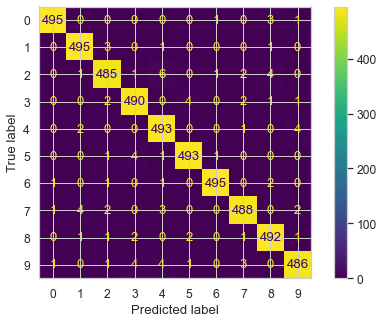

In [45]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train))
cmd.plot();

In [46]:
print(f'train set accuracy_score = {accuracy_score(y_train, y_train_rbf_pred)}')

# train set accuracy_score = 0.9818     # Again overfitting??

train set accuracy_score = 0.9824


##### **2.4.2:  Test Confusion Matrix. Test Accuracy: ~95%**

Let's visualize the test-set confusion matrix and report the test accuracy of this model

In [47]:
y_test_rbf_pred = rbf_clf.predict(X_test)   # "predict" function of scikit's svm library

In [48]:
cm = confusion_matrix(y_test, y_test_rbf_pred)
cm

array([[490,   0,   0,   0,   2,   2,   5,   0,   1,   0],
       [  0, 488,   4,   2,   0,   1,   3,   0,   2,   0],
       [  3,   0, 481,   2,   2,   0,   2,   4,   6,   0],
       [  0,   0,   6, 475,   0,   6,   0,   5,   7,   1],
       [  0,   0,   3,   0, 485,   0,   3,   0,   0,   9],
       [  2,   1,   2,   7,   0, 475,   7,   1,   5,   0],
       [  5,   2,   4,   0,   2,   4, 482,   0,   1,   0],
       [  1,   8,  14,   0,   4,   1,   0, 461,   3,   8],
       [  1,   1,   1,   5,   5,   8,   3,   3, 471,   2],
       [  3,   2,   2,   4,  13,   3,   0,   5,   8, 460]], dtype=int64)

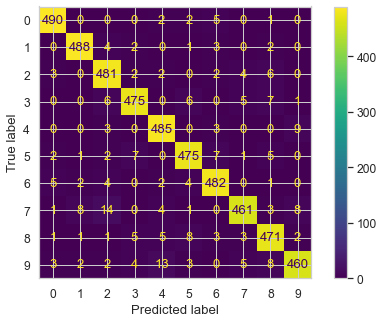

In [49]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [50]:
print(f'--> SVM(kernel=rbf): test set accuracy_score = {round(accuracy_score(y_test, y_test_rbf_pred),4)}')

# --> SVM(kernel=rbf): test set accuracy_score = 0.9536

--> SVM(kernel=rbf): test set accuracy_score = 0.9536


#### **2.5: Linear vs Radial Kernel results.**

Let's summarize results:

- LinearSVM: test set accuracy_score = 0.854
- SVM(kernel=rbf): test set accuracy_score = 0.9516

For the moment, it seems Radial kernel is better. It shows the highest accuracy on the test dataset.

### 3. SVM Hyper-parameter tuning by using cross-validation.

As seen in 2.5, we already have close to 94% test set accuracy via simplest forms of SVMs. Hence, it will be an interesting task to tune additional parameters via cross-validation, and to see if the test performance can be improved even further.

By using cross-validation, we will compare SVCs with different Kernels, parameters, as well as one-versus-one approach. We will report the test error of the model picked.

##### **3.1 GridSearchCV: 'brute force' hyperparameter tuning. Training time: ~31.5 mins**

Let's define the following search space:

In [51]:
kernels = ('linear', 'poly', 'rbf')
Cs = (0.001, 0.01, 0.1, 1, 10, 100, 1000)
degrees = (3, 8, 10)
gammas = ('auto', 'scale')

param_grid = {'kernel': kernels, 'C': Cs, 'degree': degrees, 'gamma': gammas}
param_grid

{'kernel': ('linear', 'poly', 'rbf'),
 'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
 'degree': (3, 8, 10),
 'gamma': ('auto', 'scale')}

Note that if we try to use the complete training full dataset, with 60_000 images: 

- Lets say 15 mins per fit (aprox)

- for the former search space, we are going to have: 3x7x3x2 = 126 search iterations !!

- fitting 5 folds for each of 126 candidates, totalling 630 fits

Thus: 

630 fits x 15 mins/fit = 9.450 mins = 157,5 hours = 6.5 days

**Full training dataset: expected training time: 6.5 days:**

- **We need to use an undersampled training set**

- **It is important to save search results and the fitted best model !!!**

So we will use our undersampled training dataset with 5_000 images only:

- As we already saw in 2.3, when we trained the Radial Kernel SVM, we need 2-3 sec per fit (approx).
  
Thus: 

630 fits x 3 secs/fit = 1.890 secs = 31.5 mins

**Undersampled training dataset: expected training time: 31.5 mins**

In [52]:
from sklearn.model_selection import GridSearchCV

clf = svm.SVC()
gscv = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=3)                  # 5 folds cross-validation

start = time.time()  

gscv.fit(X_train, y_train)

stop = time.time()                                                                # stop in secs, 
print(f"Searching time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format

# save the whole grid search object to disk
filename = './models/GridSearchCV_object_to_search_the_best_SVC_model_fitted_with_MNIST.joblib'
joblib.dump(gscv, filename)
print(f"GridSearchCV object saved!")

# save the model to disk
filename = './models/SVC_model_fitted_with_MNIST_and_searched_with_GridSearchCV.joblib'
joblib.dump(gscv.best_estimator_, filename)
print(f"Best model found saved!")

#Fitting 5 folds for each of 126 candidates, totalling 630 fits
#Searching time (hh:mm:ss): 0:31:26
#GridSearchCV object saved!
#Best model found saved!

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Searching time (hh:mm:ss): 0:41:35
GridSearchCV object saved!
Best model found saved!


In [53]:
filename = './models/GridSearchCV_object_to_search_the_best_SVC_model_fitted_with_MNIST.joblib'
gscv = joblib.load(filename)

# summarize results
print("--> Grid search best result: Best: %f using %s" % (gscv.best_score_, gscv.best_params_))

#means = gscv.cv_results_['mean_test_score']
#stds = gscv.cv_results_['std_test_score']
#params = gscv.cv_results_['params']

#print("--> Grid search iterations:")
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#--> Grid search best result: Best: 0.948600 using {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

--> Grid search best result: Best: 0.948600 using {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [54]:
print("--> Grid search iterations:")
results_df = pd.DataFrame(gscv.cv_results_)[['rank_test_score', 'mean_fit_time', 'params', 'mean_test_score']]
results_df.head(3)

--> Grid search iterations:


,rank_test_score,mean_fit_time,params,mean_test_score
0,69,27.557964,"{'C': 0.001, 'degree': 3, 'gamma': 'auto', 'ke...",0.8700
1,106,62.404309,"{'C': 0.001, 'degree': 3, 'gamma': 'auto', 'ke...",0.2014
2,91,69.380979,"{'C': 0.001, 'degree': 3, 'gamma': 'auto', 'ke...",0.6974


In [55]:
print("--> Grid search iterations:")
#params_df = pd.DataFrame(dict(results_df.params)).transpose()
#results_df['params'].apply(pd.Series)
results_df = pd.concat([results_df.drop('params', axis=1), pd.DataFrame(results_df['params'].tolist())], axis=1)
results_df.head(3)

--> Grid search iterations:


,rank_test_score,mean_fit_time,mean_test_score,C,degree,gamma,kernel
0,69,27.557964,0.8700,0.001,3,auto,linear
1,106,62.404309,0.2014,0.001,3,auto,poly
2,91,69.380979,0.6974,0.001,3,auto,rbf


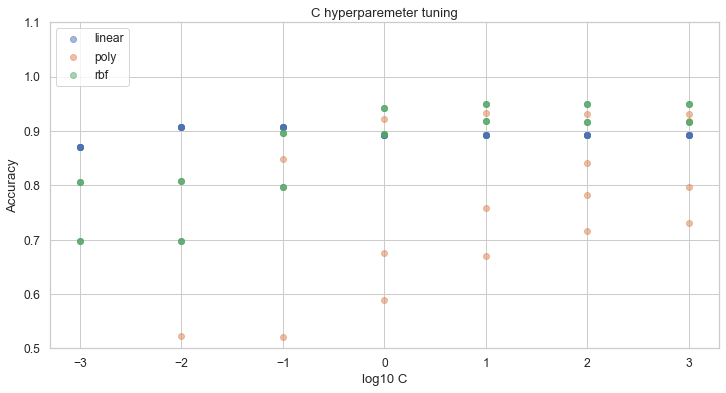

In [56]:
fig, ax = plt.subplots(figsize=(12,6))

for label, df in results_df.groupby('kernel'):
    plt.scatter(np.log10(df['C']), df['mean_test_score'], marker = 'o', label=label, alpha=0.5)

plt.ylim([0.5, 1.1])

plt.xlabel("log10 C")
plt.ylabel("Accuracy")

plt.title("C hyperparemeter tuning")

plt.legend(loc='upper left')
plt.show()

In [57]:
print("--> Grid search ordered best results by rank score and fit time: ")

results_df.sort_values(['rank_test_score', 'mean_fit_time'], inplace=True)
results_df.head()

#--> Grid search best result: Best: 0.948600 using {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

--> Grid search ordered best results by rank score and fit time: 


,rank_test_score,mean_fit_time,mean_test_score,C,degree,gamma,kernel
125,1,12.086234,0.9486,1000.0,10,scale,rbf
113,1,12.352577,0.9486,1000.0,3,scale,rbf
83,1,12.363628,0.9486,10.0,8,scale,rbf
107,1,12.436613,0.9486,100.0,10,scale,rbf
95,1,12.474439,0.9486,100.0,3,scale,rbf


##### **3.2 Evaluating GridSearchCV best model on the test dataset. Test Accuracy: ~96%**

In [58]:
#pred = ... #use "predict" function of scikit's svm library

y_test_grid_search_pred = gscv.predict(X_test)

In [59]:
#cm = confusion_matrix...

cm = confusion_matrix(y_test, y_test_grid_search_pred)
cm

array([[489,   0,   0,   0,   1,   4,   5,   0,   1,   0],
       [  1, 490,   3,   1,   0,   1,   3,   0,   1,   0],
       [  4,   0, 489,   0,   1,   0,   0,   4,   1,   1],
       [  0,   0,   7, 477,   0,   6,   0,   4,   5,   1],
       [  0,   0,   4,   0, 484,   0,   2,   0,   0,  10],
       [  2,   1,   2,   4,   0, 479,   5,   1,   6,   0],
       [  5,   1,   4,   0,   4,   6, 480,   0,   0,   0],
       [  0,   5,  15,   3,   4,   0,   0, 468,   0,   5],
       [  1,   1,   1,   6,   4,   6,   3,   2, 474,   2],
       [  3,   2,   2,   5,   9,   3,   0,   5,   7, 464]], dtype=int64)

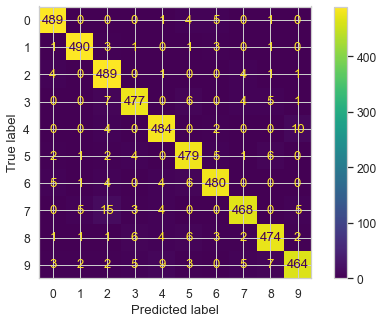

In [60]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [61]:
#accuracy_score ... #use the "sklearn.metric.accuracy_score" to return this (other options are also fine)

print(f'test set accuracy_score = {round(accuracy_score(y_test, y_test_grid_search_pred),4)}')

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

test set accuracy_score = 0.9588


##### **3.3 BayesSearchCV: CVM hyperparameter tuning with Bayes Optimization. Training time: ~21.5 mins**

Search for parameters of machine learning models that result in best cross-validation performance is necessary in almost all practical cases to get a model with best generalization estimate.

A standard approach in scikit-learn is using **sklearn.model_selection.GridSearchCV** class, which takes a set of values for every parameter to try, and simply enumerates all combinations of parameter values. 

**As we have seen, the complexity of such search grows exponentially with the addition of new parameters:**

**32 hours of training for the full MNIST example in our laptop!!!.** 

A more scalable approach is using **sklearn.model_selection.RandomizedSearchCV**, which however does not take advantage of the structure of a search space.

Scikit-optimize provides **skopt.BayesSearchCV** as a drop-in replacement for sklearn.model_selection.GridSearchCV, which ***utilizes Bayesian Optimization where a predictive model referred to as “surrogate” is used to model the search space and utilized to arrive at good parameter values combination as soon as possible***.

- https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html 
- https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
- https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html
- https://scikit-optimize.github.io/stable/install.html

In [62]:
from skopt import BayesSearchCV                     # pip install scikit-optimize 
                                                    # conda install -c conda-forge scikit-optimize
#from sklearn.datasets import load_digits
#from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split

#X, y = load_digits(n_class=10, return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
bayes_opt = BayesSearchCV(
    svm.SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),     # float valued parameter
        'gamma': (1e-6, 1e+1, 'log-uniform'), # float valued parameter
        'degree': (1, 8),                     # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=64,                                # 64 iterations !!
    cv=5,
    verbose=True
)

Note that Grid Search Optimization uses a discrete dimensions, and thus a completely discrete search space: 

```python
kernels = ('linear', 'poly', 'rbf')
Cs = (0.001, 0.01, 0.1, 1, 10, 100, 1000)
degrees = (3, 8, 10)
gammas = ('auto', 'scale')

param_grid = {'kernel': kernels, 'C': Cs, 'degree': degrees, 'gamma': gammas}
param_grid
```

Now, with Bayesian Optimization, we can naturally use continuous dimensions. In our example `C` and `gamma` now are considered as continuous values between `0.000_001` and `1_000_000`. That means that searched space is "more dense" and solved optimization problem harder.     

**Counting total iterations that will be used to explore all subspaces:**

Subspaces in previous examples can further increase in complexity if you add new model subspaces or dimensions for feature extraction pipelines. 

For monitoring of progress, you would like to know the total number of iterations it will take to explore all subspaces. 

This can be calculated with total_iterations property, as in the code below.

In [63]:
print(bayes_opt.total_iterations)

256


**Progress monitoring and control using callback argument of fit method:**

It is possible to monitor the progress of BayesSearchCV with an event handler that is called on every step of subspace exploration. For single job mode, this is called on every evaluation of model configuration, and for parallel mode, this is called when n_jobs model configurations are evaluated in parallel.

Additionally, exploration can be stopped if the callback returns True. This can be used to stop the exploration early, for instance when the accuracy that you get is sufficiently high.

In [64]:
# callback handler
def on_step(optim_result):
    score = bayes_opt.best_score_
    print("best score: %s" % score)
    if score >= 0.95:
        print('Interrupting!')
        return True

**Optimization step:**

A minimal example of optimizing hyperparameters of SVC (Support Vector machine Classifier) is given below.

Training time can be high. At the end of the fitting, automatically found best model object and the whole grid search object, both are saved to disk.

In [65]:
start = time.time()  

bayes_opt.fit(X_train, y_train) 
#bayes_opt.fit(X_train, y_train, callback=on_step)

stop = time.time()                                                                # stop in secs, 
print(f"Searching time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format

# save the whole bayes search object to disk
filename = './models/BayesSearchCV_object_to_search_the_best_SVC_model_fitted_with_MNIST.joblib'
joblib.dump(bayes_opt, filename)
print(f"BayesSearchCV object saved!")

# save the best model to disk
filename = './models/SVC_model_fitted_with_MNIST_and_searched_with_BayesSearchCV.joblib'
joblib.dump(bayes_opt.best_estimator_, filename)
print(f"Best model found saved!")

# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# ...
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Searching time (hh:mm:ss): 0:20:07
# BayesSearchCV object saved!
# Best model found saved!

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

**Model load and performace metrics:**

In [66]:
filename = './models/BayesSearchCV_object_to_search_the_best_SVC_model_fitted_with_MNIST.joblib'
bayes_opt = joblib.load(filename)

# summarize results
print("--> Bayes search best result: Best: %f using %s" % (bayes_opt.best_score_, bayes_opt.best_params_))

#means = bayes_opt.cv_results_['mean_test_score']
#stds = bayes_opt.cv_results_['std_test_score']
#params = bayes_opt.cv_results_['params']
#print("--> Bayes search iterations:")
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))


--> Bayes search best result: Best: 0.941600 using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])


In [67]:
# pred ... # predict the training set
train_y_bayes_opt_pred = bayes_opt.predict(X_train)   

In [68]:
#cm = confusion_matrix...
cm = confusion_matrix(y_train, train_y_bayes_opt_pred)
cm

array([[500,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 500]], dtype=int64)

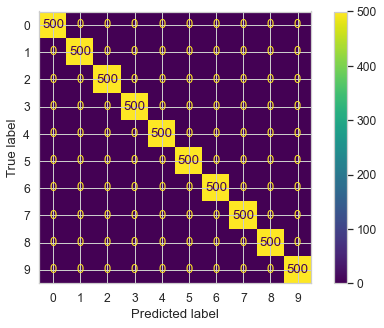

In [69]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train))
cmd.plot();

In [70]:
print("val. score: %s" % bayes_opt.best_score_)
print("test score: %s" % bayes_opt.score(X_test, y_test))

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

#val. score: 0.9415999999999999
#test score: 0.9552                                 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

val. score: 0.9415999999999999
test score: 0.9552


**Plot performance metrics during search:** 

In [71]:
results_df = pd.DataFrame(bayes_opt.cv_results_)[['rank_test_score', 'mean_fit_time', 'params', 'mean_test_score']]
results_df.head(10)

,rank_test_score,mean_fit_time,params,mean_test_score
0,62,5.568728,"{'C': 0.0029953698955455183, 'degree': 5, 'gam...",0.1328
1,50,2.067186,"{'C': 587767.869800126, 'degree': 6, 'gamma': ...",0.8502
2,20,1.020539,"{'C': 63.36435326098133, 'degree': 5, 'gamma':...",0.8930
3,64,6.521624,"{'C': 191629.5238519232, 'degree': 8, 'gamma':...",0.1094
4,63,6.973017,"{'C': 3.7175335068159175e-05, 'degree': 7, 'ga...",0.1160
5,49,3.430175,"{'C': 0.0006548041063943216, 'degree': 4, 'gam...",0.8516
6,56,6.716647,"{'C': 3.2997191972026555e-05, 'degree': 6, 'ga...",0.6756
7,61,6.986258,"{'C': 66487.23048691716, 'degree': 4, 'gamma':...",0.1938
8,20,0.968297,"{'C': 1.2468794675278196, 'degree': 3, 'gamma'...",0.8930
9,20,1.049191,"{'C': 59023.811607367956, 'degree': 5, 'gamma'...",0.8930


In [72]:
#params_df = pd.DataFrame(dict(results_df.params)).transpose()
#results_df['params'].apply(pd.Series)
results_df = pd.concat([results_df.drop('params', axis=1), pd.DataFrame(results_df['params'].tolist())], axis=1)
results_df.head(10)

,rank_test_score,mean_fit_time,mean_test_score,C,degree,gamma,kernel
0,62,5.568728,0.1328,0.002995,5,0.000471,poly
1,50,2.067186,0.8502,587767.869800,6,0.051351,poly
2,20,1.020539,0.8930,63.364353,5,0.000057,linear
3,64,6.521624,0.1094,191629.523852,8,0.000062,poly
4,63,6.973017,0.1160,0.000037,7,0.584264,rbf
5,49,3.430175,0.8516,0.000655,4,0.000029,linear
6,56,6.716647,0.6756,0.000033,6,0.044799,linear
7,61,6.986258,0.1938,66487.230487,4,0.954197,rbf
8,20,0.968297,0.8930,1.246879,3,5.522764,linear
9,20,1.049191,0.8930,59023.811607,5,0.000010,linear


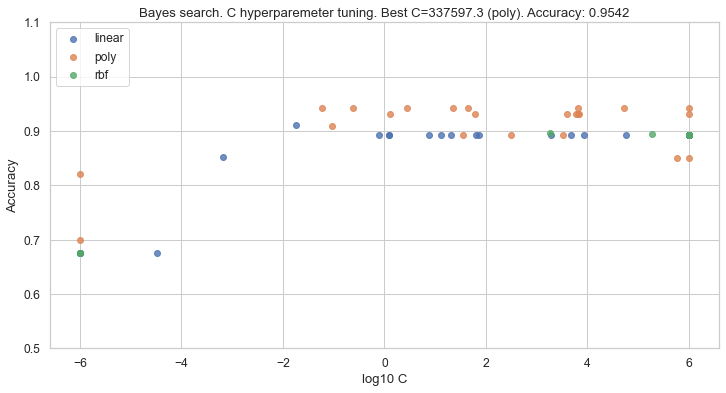

In [73]:
fig, ax = plt.subplots(figsize=(12,6))

for label, df in results_df.groupby('kernel'):
    plt.scatter(np.log10(df['C']), df['mean_test_score'], marker = 'o', label=label, alpha=0.8)

plt.ylim([0.5, 1.1])

plt.xlabel("log10 C")
plt.ylabel("Accuracy")

plt.title("Bayes search. C hyperparemeter tuning. Best C=337597.3 (poly). Accuracy: 0.9542")

plt.legend(loc='upper left')
plt.show()

#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

In [74]:
results_df.sort_values(['rank_test_score', 'mean_fit_time'], inplace=True)
results_df.head()

,rank_test_score,mean_fit_time,mean_test_score,C,degree,gamma,kernel
27,1,0.959087,0.9416,53078.023320,2,0.357796,poly
62,1,0.965679,0.9416,0.057812,2,10.000000,poly
61,1,0.970768,0.9416,1000000.000000,2,0.298563,poly
33,1,0.981266,0.9416,6570.949235,2,0.631026,poly
55,1,0.994065,0.9416,0.237985,2,10.000000,poly


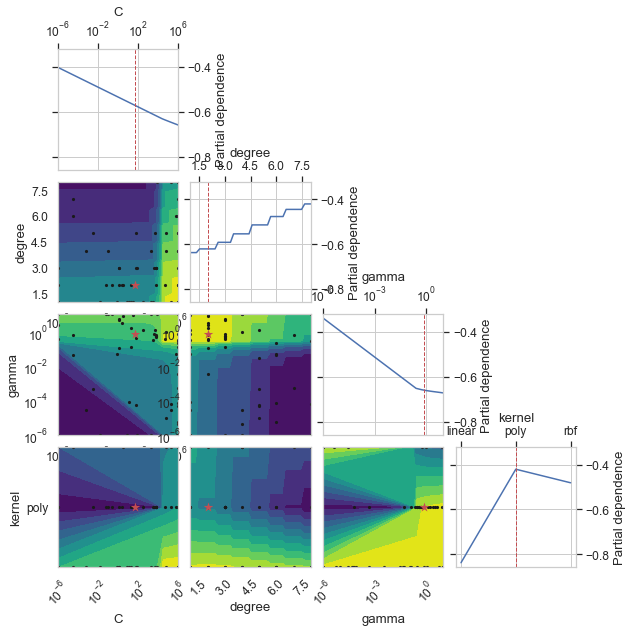

In [75]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(bayes_opt.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

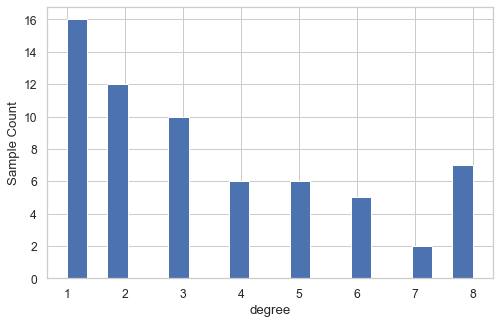

In [76]:
_ = plot_histogram(bayes_opt.optimizer_results_[0], 1)
plt.show()

##### **3.4 Evaluating BayesSearchCV best model on the test dataset. Test Accuracy: ~96.5%**

In [77]:
#pred = ... #use "predict" function of scikit's svm library

y_test_bayes_search_pred = bayes_opt.predict(X_test)

In [78]:
#cm = confusion_matrix...

cm = confusion_matrix(y_test, y_test_bayes_search_pred)
cm

array([[492,   0,   0,   0,   0,   3,   4,   0,   1,   0],
       [  0, 487,   3,   2,   0,   1,   3,   1,   3,   0],
       [  4,   3, 482,   0,   2,   1,   2,   4,   2,   0],
       [  0,   2,   9, 472,   0,   6,   0,   4,   6,   1],
       [  1,   0,   3,   0, 483,   0,   2,   1,   0,  10],
       [  3,   4,   0,   8,   0, 473,   5,   1,   5,   1],
       [  7,   1,   2,   0,   5,   6, 478,   0,   1,   0],
       [  0,  10,   9,   1,   3,   0,   0, 473,   1,   3],
       [  3,   1,   1,   7,   4,   6,   3,   1, 468,   6],
       [  6,   2,   1,   2,  10,   2,   0,   6,   3, 468]], dtype=int64)

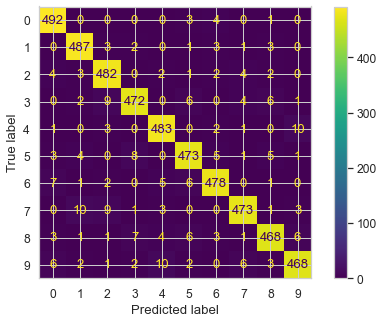

In [79]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [80]:
#accuracy_score ... #use the "sklearn.metric.accuracy_score" to return this (other options are also fine)

print(f'--> Bayes Search: test set accuracy_score = {round(accuracy_score(y_test, y_test_bayes_search_pred),4)}')

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

--> Bayes Search: test set accuracy_score = 0.9552


**Summary:**

Following are presented the results for one complete execution of the notebook: 

- LinearSVM: test set accuracy_score = 0.8732
- SVM(kernel=rbf): test set accuracy_score = 0.9536
- Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
- Bayes Search: test set accuracy_score = 0.9552  --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

Note that the results might change slightly between notebook executions.

### 4. MLP Model Training.

#### **4.1: Training an MLP based classifier.Training time: ~21 secs**

In [81]:
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# # Load data from https://www.openml.org/d/554
# X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
# X = X / 255.0

# # Split data into train partition and test partition
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

mlp_clf = MLPClassifier(
          hidden_layer_sizes=(784, 128),
          max_iter=100,
          alpha=1e-4,
          solver="sgd",
          learning_rate_init=0.2,
          random_state=1,
          verbose=10,
)

start = time.time()         

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

mlp_clf.fit(X_train, y_train)                                                  # fit the mlp_clf to the training set

stop = time.time()                                                                 # stop in secs, 

print(f"\nTraining time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format
print(f"Convergence after: {mlp_clf.n_iter_} iterations")

# save the model to disk
filename = './models/MLP_fitted_with_MNIST_undersampled.joblib'
joblib.dump(lin_clf, filename)
print(f"Trained model saved!")

print("\nTraining set score: %f" % mlp_clf.score(X_train, y_train))
print("Test set score: %f" % mlp_clf.score(X_test, y_test))

# Iteration 1, loss = 1.49614295
# Iteration 2, loss = 0.47615498
# Iteration 3, loss = 0.20161587
# ...
# Iteration 25, loss = 0.00082163
# Iteration 26, loss = 0.00079889
# Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

# Training time (hh:mm:ss): 0:00:21
# Convergence after: 26 iterations
# Trained model saved!

# Training set score: 1.000000
# Test set score: 0.954400

Iteration 1, loss = 1.49614295
Iteration 2, loss = 0.47615498
Iteration 3, loss = 0.20161587
Iteration 4, loss = 0.11210526
Iteration 5, loss = 0.06566951
Iteration 6, loss = 0.03317718
Iteration 7, loss = 0.01346817
Iteration 8, loss = 0.00730002
Iteration 9, loss = 0.00392192
Iteration 10, loss = 0.00248988
Iteration 11, loss = 0.00198326
Iteration 12, loss = 0.00168943
Iteration 13, loss = 0.00149515
Iteration 14, loss = 0.00136746
Iteration 15, loss = 0.00126205
Iteration 16, loss = 0.00117872
Iteration 17, loss = 0.00111393
Iteration 18, loss = 0.00105909
Iteration 19, loss = 0.00100735
Iteration 20, loss = 0.00096609
Iteration 21, loss = 0.00092858
Iteration 22, loss = 0.00089626
Iteration 23, loss = 0.00087033
Iteration 24, loss = 0.00084512
Iteration 25, loss = 0.00082163
Iteration 26, loss = 0.00079889
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Training time (hh:mm:ss): 0:00:21
Convergence after: 26 iterations
Trained model saved

#### **4.2: MLP classifier evaluation**

##### **4.2.1: Training Confusion Matrix. Training Accuracy: ~100%**

Let's  plot the confusion matrix obtained in the training set with that new class of SVM, and report the accuracy.

In [82]:
y_train_mlp_pred = mlp_clf.predict(X_train)   

In [83]:
cm = confusion_matrix(y_train, y_train_mlp_pred)
cm

array([[500,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 500]], dtype=int64)

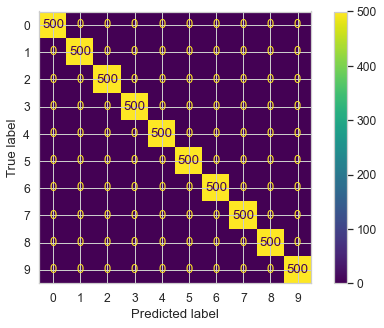

In [84]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train))
cmd.plot();

In [85]:
print(f'train set accuracy_score = {accuracy_score(y_train, y_train_mlp_pred)}')

# train set accuracy_score = 1.0     # Again overfitting??

train set accuracy_score = 1.0


##### **4.4.2:  Test Confusion Matrix. Test Accuracy: ~95%**

Let's visualize the test-set confusion matrix and report the test accuracy of this model

In [86]:
y_test_mlp_pred = mlp_clf.predict(X_test)   # "predict" function of scikit's svm library

In [87]:
cm = confusion_matrix(y_test, y_test_mlp_pred)
cm

array([[487,   0,   0,   1,   0,   2,   6,   0,   3,   1],
       [  0, 486,   4,   2,   0,   1,   4,   1,   2,   0],
       [  2,   1, 484,   2,   0,   3,   2,   4,   2,   0],
       [  0,   1,   7, 475,   0,   6,   0,   3,   5,   3],
       [  2,   0,   4,   0, 471,   0,   6,   0,   4,  13],
       [  6,   2,   0,   5,   1, 470,   8,   2,   5,   1],
       [  4,   1,   3,   1,   5,   3, 481,   0,   2,   0],
       [  0,   3,   8,   3,   2,   0,   0, 477,   0,   7],
       [  1,   1,   2,   4,   2,   3,   5,   2, 477,   3],
       [  3,   2,   2,   2,  13,   2,   0,   7,   5, 464]], dtype=int64)

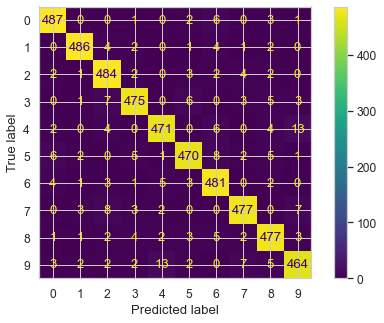

In [88]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [89]:
print(f'--> MLP: test set accuracy_score = {round(accuracy_score(y_test, y_test_mlp_pred),4)}')

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

# --> MLP: test set accuracy_score = 0.9504

--> MLP: test set accuracy_score = 0.9544


### 5. MLP Hyper-parameter tuning by using cross-validation.

##### **5.1 BayesSearchCV: MLP hyperparameter tuning with Bayes Optimization. Training time: ~ 3h 30mins**

In [90]:
from skopt import BayesSearchCV                     # pip install scikit-optimize 
                                                    # conda install -c conda-forge scikit-optimize
#from sklearn.datasets import load_digits
#from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split

#X, y = load_digits(n_class=10, return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

bayes_opt2 = BayesSearchCV(
    MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1_000, random_state=1),
    {                                                             # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
        'activation': ['logistic', 'relu'],                       # categorical parameter
        #'alpha': (1e-6, 1e+1, 'log-uniform'),                     # float valued parameter
        #'learning_rate': ['constant', 'invscaling', 'adaptive'],  # categorical parameter
        'solver': ['sgd', 'adam']                                 # categorical parameter
    },
    n_iter=10,                                                    # 10 (bayes opt) iterations !!
    cv=5,
    verbose=True
)

print(bayes_opt2.total_iterations)

20


**Optimization step:**

A minimal example of optimizing hyperparameters of SVC (Support Vector machine Classifier) is given below.

Training time can be high. At the end of the fitting, automatically found best model object and the whole grid search object, both are saved to disk.

In [91]:
start = time.time()  

bayes_opt2.fit(X_train, y_train) 
#bayes_opt2.fit(X_train, y_train, callback=on_step)

stop = time.time()                                                                # stop in secs, 
print(f"Searching time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format

# save the whole bayes search object to disk
filename = './models/BayesSearchCV2_object_to_search_the_best_MLP_model_fitted_with_MNIST.joblib'
joblib.dump(bayes_opt2, filename)
print(f"BayesSearchCV2 object saved!")

# save the best model to disk
filename = './models/MLP_model_fitted_with_MNIST_and_searched_with_BayesSearchCV2.joblib'
joblib.dump(bayes_opt2.best_estimator_, filename)
print(f"Best model found saved!")

# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# ...
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Searching time (hh:mm:ss): 3:27:30
# BayesSearchCV2 object saved!
# Best model found saved!

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\min

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\min

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gustavo\min

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Searching time (hh:mm:ss): 3:27:30
BayesSearchCV2 object saved!
Best model found saved!


**Model load and performace metrics:**

In [115]:
filename = './models/BayesSearchCV2_object_to_search_the_best_MLP_model_fitted_with_MNIST.joblib'
bayes_opt2 = joblib.load(filename)

# summarize results
print("--> Bayes search best training result: Best: %f using %s" % (bayes_opt2.best_score_, bayes_opt2.best_params_))

#means = bayes_opt2.cv_results_['mean_test_score']
#stds = bayes_opt2.cv_results_['std_test_score']
#params = bayes_opt2.cv_results_['params']
#print("--> Bayes search iterations:")
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#--> Bayes search best result: Best: 0.940600 using OrderedDict([('activation', 'relu'), ('solver', 'adam')])

--> Bayes search best training result: Best: 0.940600 using OrderedDict([('activation', 'relu'), ('solver', 'adam')])


In [116]:
# pred ... # predict the training set
train_y_bayes_opt2_pred = bayes_opt2.predict(X_train)   

In [117]:
#cm = confusion_matrix...
cm = confusion_matrix(y_train, train_y_bayes_opt2_pred)
cm

array([[500,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 500]], dtype=int64)

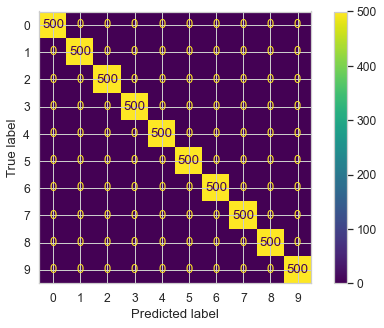

In [112]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train))
cmd.plot();

In [114]:
print("val. score: %s" % bayes_opt2.best_score_)
print("test score: %s" % bayes_opt2.score(X_test, y_test))

#val. score: 0.9405999999999999
#test score: 0.9544                                 --> Bayes search best result: Best: 0.940600 using OrderedDict([('activation', 'relu'), ('solver', 'adam')])

val. score: 0.9405999999999999
test score: 0.9544


**Plot performance metrics during search:** 

In [97]:
results_df = pd.DataFrame(bayes_opt2.cv_results_)[['rank_test_score', 'mean_fit_time', 'params', 'mean_test_score']]
results_df.head(10)

,rank_test_score,mean_fit_time,params,mean_test_score
0,1,31.591547,"{'activation': 'relu', 'solver': 'adam'}",0.9406
1,6,92.542481,"{'activation': 'logistic', 'solver': 'adam'}",0.9284
2,8,585.388114,"{'activation': 'logistic', 'solver': 'sgd'}",0.8674
3,8,601.019866,"{'activation': 'logistic', 'solver': 'sgd'}",0.8674
4,1,34.364092,"{'activation': 'relu', 'solver': 'adam'}",0.9406
5,1,36.275265,"{'activation': 'relu', 'solver': 'adam'}",0.9406
6,1,34.076634,"{'activation': 'relu', 'solver': 'adam'}",0.9406
7,7,347.884410,"{'activation': 'relu', 'solver': 'sgd'}",0.9262
8,8,683.120082,"{'activation': 'logistic', 'solver': 'sgd'}",0.8674
9,1,33.637330,"{'activation': 'relu', 'solver': 'adam'}",0.9406


In [98]:
#params_df = pd.DataFrame(dict(results_df.params)).transpose()
#results_df['params'].apply(pd.Series)
results_df = pd.concat([results_df.drop('params', axis=1), pd.DataFrame(results_df['params'].tolist())], axis=1)
results_df.head(10)

,rank_test_score,mean_fit_time,mean_test_score,activation,solver
0,1,31.591547,0.9406,relu,adam
1,6,92.542481,0.9284,logistic,adam
2,8,585.388114,0.8674,logistic,sgd
3,8,601.019866,0.8674,logistic,sgd
4,1,34.364092,0.9406,relu,adam
5,1,36.275265,0.9406,relu,adam
6,1,34.076634,0.9406,relu,adam
7,7,347.884410,0.9262,relu,sgd
8,8,683.120082,0.8674,logistic,sgd
9,1,33.637330,0.9406,relu,adam


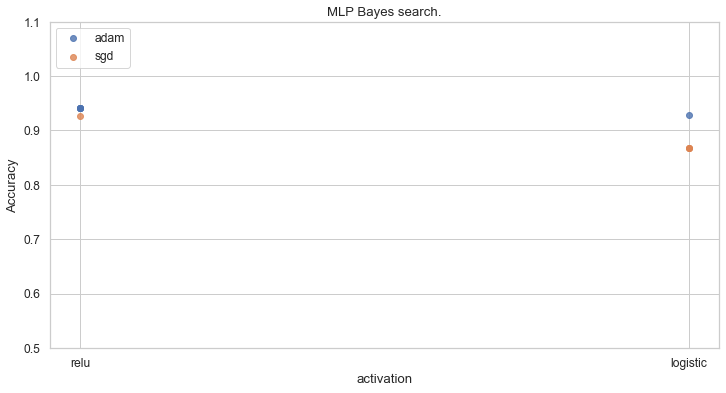

In [100]:
fig, ax = plt.subplots(figsize=(12,6))

for label, df in results_df.groupby('solver'):
    plt.scatter(df['activation'], df['mean_test_score'], marker = 'o', label=label, alpha=0.8)

plt.ylim([0.5, 1.1])

plt.xlabel("activation")
plt.ylabel("Accuracy")

plt.title("MLP Bayes search.")

plt.legend(loc='upper left')
plt.show()

In [101]:
results_df.sort_values(['rank_test_score', 'mean_fit_time'], inplace=True)
results_df.head()

,rank_test_score,mean_fit_time,mean_test_score,activation,solver
0,1,31.591547,0.9406,relu,adam
9,1,33.637330,0.9406,relu,adam
6,1,34.076634,0.9406,relu,adam
4,1,34.364092,0.9406,relu,adam
5,1,36.275265,0.9406,relu,adam


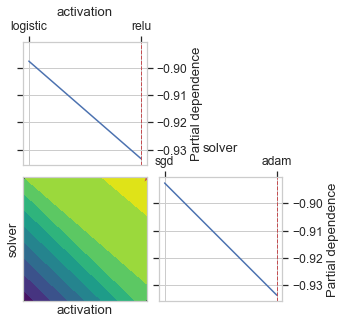

In [102]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(bayes_opt2.optimizer_results_[0],
                   dimensions=["activation", "solver"],
                   n_minimum_search=int(1e8))
plt.show()

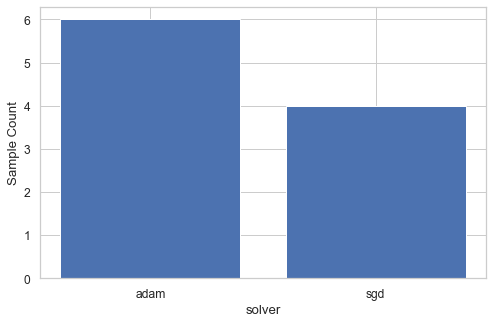

In [103]:
_ = plot_histogram(bayes_opt2.optimizer_results_[0], 1)
plt.show()

##### **5.2 Evaluating BayesSearchCV best model on the test dataset. Test Accuracy: ~95.5%**

In [118]:
#pred = ... #use "predict" function of scikit's svm library

y_test_bayes2_search_pred = bayes_opt2.predict(X_test)

In [119]:
#cm = confusion_matrix...

cm = confusion_matrix(y_test, y_test_bayes2_search_pred)
cm

array([[487,   0,   0,   1,   1,   1,   7,   1,   2,   0],
       [  0, 489,   3,   1,   0,   1,   3,   0,   3,   0],
       [  3,   1, 479,   2,   0,   0,   3,   6,   5,   1],
       [  1,   0,   8, 471,   1,   7,   0,   2,   6,   4],
       [  1,   0,   4,   0, 479,   0,   3,   1,   2,  10],
       [  3,   2,   0,   8,   1, 471,   7,   3,   4,   1],
       [  2,   1,   2,   1,   5,   6, 481,   0,   2,   0],
       [  1,   2,  11,   3,   4,   0,   0, 472,   0,   7],
       [  3,   1,   1,   6,   2,   2,   5,   3, 477,   0],
       [  6,   2,   1,   4,   9,   1,   0,   7,   4, 466]], dtype=int64)

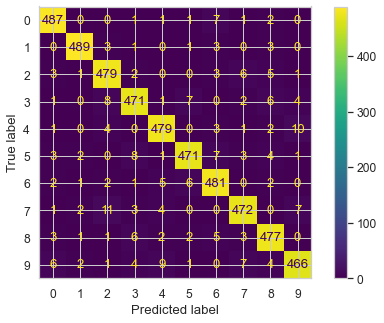

In [120]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [121]:
#accuracy_score ... #use the "sklearn.metric.accuracy_score" to return this (other options are also fine)

print(f'--> Bayes Search 2: test set accuracy_score = {round(accuracy_score(y_test, y_test_bayes2_search_pred),4)}')

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

#--> Bayes Search 2: test set accuracy_score = 0.9544 --> Bayes search best result: using OrderedDict([('activation', 'relu'), ('solver', 'adam')])


--> Bayes Search 2: test set accuracy_score = 0.9544


### 6. Evaluating different ML model families with Sklearn BayesSearchCV and Pipes: a more comprehensive example

In practice, one wants to enumerate over multiple predictive model classes, with different search spaces and number of evaluations per class. 

We present here an example of such search over parameters of SVM and MLP family models.

#### **6.1 Data preparation and scaling steps in the pipeline**

Let's see how to integrate the scaling step in the pipeline:

In [177]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# starting from the undersampled dataset:
X_train = train_undersampled_2.iloc[:,1:]   #predictors of the training set
y_train = train_undersampled_2.iloc[:,0]    #targets (true digits) of the training set

# starting from the undersampled dataset:
X_test= test_undersampled_2.iloc[:,1:]      #predictors of the testing set
y_test = test_undersampled_2.iloc[:,0]      #targets (true digits) of the testing set

# We have to integrate that code in the pipeline:
# scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
# X_train = scaling.transform(X_train)
# X_test = scaling.transform(X_test)

column_transf = ColumnTransformer(
    [('scaling', MinMaxScaler(feature_range=(0,1)), [col for col in X_train.columns])],  
    remainder='passthrough')

column_transf.fit(X_train) 
X_train = column_transf.transform(X_train)

column_transf2 = ColumnTransformer(
    [('scaling', MinMaxScaler(feature_range=(0,1)), [col for col in X_test.columns])],  
    remainder='passthrough')

column_transf2.fit(X_test) 
X_test = column_transf2.transform(X_test)

#### **6.2 Complete Sklearn pipeline to compare SVMs and NN models by getting their best performing hyperparams using Bayes Optimization**

In [123]:
from skopt import BayesSearchCV                     # pip install scikit-optimize 
                                                    # conda install -c conda-forge scikit-optimize
from skopt.space import Real, Categorical, Integer
#from skopt.plots import plot_objective, plot_histogram

#from sklearn.datasets import load_digits
#from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#X, y = load_digits(n_class=10, return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# starting from the undersampled dataset:
X_train = train_undersampled_2.iloc[:,1:]   #predictors of the training set
y_train = train_undersampled_2.iloc[:,0]    #targets (true digits) of the training set

print(X_train.shape)
print(y_train.shape)

column_transf = ColumnTransformer(
    [('scaling', MinMaxScaler(feature_range=(-1,1)), [col for col in X_train.columns])],  
    remainder='passthrough')

# pipeline class is used as estimator to enable search over different model types
pipe = Pipeline(steps = [('preprocess', column_transf), 
                         ('model', svm.SVC())])                # model here is a kind of variable: its value will be redefined in the next search spaces.

# explicit dimension classes - Real, Categorical, Integer - can be specified like this:
svc_search = {
    'model': Categorical([svm.SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),         # log-uniform: understand as search over p = exp(x) by varying x
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),     # log-uniform: understand as search over p = exp(x) by varying x
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

nn_search = {
    'model': Categorical([MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1_000, random_state=1)]),
                                                               # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    'model__activation' : Categorical(['logistic', 'relu']),
    #'model__alpha': Real(1e-6, 1, prior='log-uniform'),       # log-uniform: understand as search over p = exp(x) by varying x
    #'model__learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),  
    'model__solver': Categorical(['sgd', 'adam']),
}

bayes_opt3 = BayesSearchCV(
    estimator=pipe,              
    search_spaces=[(svc_search, 8), (nn_search, 8)],           # (parameter space, # of evaluations) = (grid_search, n_iter)
    scoring="accuracy",
    cv=5,
    verbose=3,                                                 # verbose=3 better than verbose=True only: you have to know there is no convergence problems, 
                                                               # if not, results (scores) are not valid, and even the saved model could not be able to predict
    random_state=1
)

print(bayes_opt3.total_iterations)

(5000, 784)
(5000,)
16


#### **6.3 Getting the result of each optimization step using callbacks**

In [137]:
# callback handler
def on_step(optim_result):
    score = bayes_opt3.best_score_
    print("best score: %s" % score)                               # AttributeError !!: 'BayesSearchCV' object has no attribute 'best_score_' 
    if score >= 0.97:                                             # 0.96 is the best score we have found: we can stop the search with a small improvement
        print('Interrupting!')
        return True

In [138]:
import pandas as pd
import numpy as np

# callback handler
def print_status(optimal_result):
    """Shows the best parameters found and accuracy attained of the search so far."""

    models_tested = pd.DataFrame(bayes_opt3.cv_results_)          # AttributeError !!: 'BayesSearchCV' object has no attribute 'cv_results_'
    best_parameters_so_far = pd.Series(bayes_opt3.best_params_)
    
    print(
        "Model #{}\nBest accuracy so far: {}\nBest parameters so far: {}\n".format(
            len(models_tested),
            np.round(bayes_opt3.best_score_, 3),
            bayes_opt3.best_params_,
        )
    )

    clf_type = bayes_opt3.estimator.__class__.__name__
    models_tested.to_csv(clf_type + "_cv_results_summary.csv")

    # Borrowed from here: https://subscription.packtpub.com/book/security/9781789614671/1/ch01lvl1sec12/hyperparameter-tuning-with-scikit-optimize

#### **6.4 BayesSearchCV: MLP hyperparameter tuning with Bayes Optimization. Training time: ~ 3h**

In [139]:
start = time.time()  

bayes_opt3.fit(X_train, y_train) 
#bayes_opt3.fit(X_train, y_train, callback=on_step)                            
#result = bayes_opt3.fit(X_train, y_train, callback=print_status)

stop = time.time()                                                                # stop in secs, 
print(f"Searching time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format

# save the whole bayes search object to disk
filename = './models/BayesSearchCV3_object_to_search_the_best_model_fitted_with_MNIST.joblib'
joblib.dump(bayes_opt3, filename)
print(f"BayesSearchCV3 object saved!")

# save the best model to disk
filename = './models/Best_model_fitted_with_MNIST_and_searched_with_BayesSearchCV3.joblib'
joblib.dump(bayes_opt3.best_estimator_, filename)
print(f"Best model found saved!")

print("val. score: %s" % bayes_opt3.best_score_)
#print("test score: %s" % bayes_opt3.score(X_test, y_test))
print("best params: %s" % str(bayes_opt3.best_params_))

# Execution Results: ------------------------------------------------------------------------------------------------------------------------------
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# [CV 1/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.692 total time=   8.2s
# [CV 2/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.667 total time=   8.1s
# [CV 3/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.671 total time=   8.1s
# [CV 4/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.669 total time=   7.0s
# [CV 5/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.679 total time=   7.0s
# ... 
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# [CV 1/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.951 total time= 1.5min
# [CV 2/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.924 total time= 1.4min
# [CV 3/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.927 total time= 1.3min
# [CV 4/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.937 total time= 1.3min
# [CV 5/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.933 total time= 1.3min
# Searching time (hh:mm:ss): 2:55:50
# BayesSearchCV3 object saved!
# Best model found saved!
# val. score: 0.9490000000000001
# best params: OrderedDict([('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly')), ('model__C', 735.4496833294961), ('model__degree', 7), ('model__gamma', 0.006630670566664593), ('model__kernel', 'poly')])


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.692 total time=   8.2s
[CV 2/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.667 total time=   8.1s
[CV 3/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.671 total time=   8.1s
[CV 4/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.669 total time=   7.0s
[CV 5/5] END model=SVC(), model__C=0.010358062862842844, model__degree=1, model__gamma=0.0011051597089741824, model__kernel=poly;, score=0.679 total time=   7.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model=SVC(), model__C=1.4500687927848266e-06, model__degree

c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.888 total time= 8.7min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.872 total time= 9.4min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.893 total time= 9.4min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.900 total time= 9.5min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.899 total time= 9.3min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.951 total time= 1.3min
[CV 2/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.924 total time= 1.3min
[CV 3/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.927 total time= 1.3min
[CV 4/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.937 total time= 1.3min
[CV 5/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128)

c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.888 total time= 9.6min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.872 total time= 9.4min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.893 total time= 9.5min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.900 total time= 9.4min


c:\Users\Gustavo\miniconda3\envs\sci\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=sgd;, score=0.899 total time= 9.8min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.951 total time= 1.5min
[CV 2/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.924 total time= 1.4min
[CV 3/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.927 total time= 1.3min
[CV 4/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128), max_iter=1000, random_state=1), model__activation=logistic, model__solver=adam;, score=0.937 total time= 1.3min
[CV 5/5] END model=MLPClassifier(hidden_layer_sizes=(784, 128)

#### **6.5 Evaluating BayesSearchCV best model on the test dataset. Test Accuracy: ~95.5%**

In [178]:
filename = './models/BayesSearchCV3_object_to_search_the_best_model_fitted_with_MNIST.joblib'
bayes_opt3 = joblib.load(filename)

filename = './models/Best_model_fitted_with_MNIST_and_searched_with_BayesSearchCV3.joblib'
Best_model_bayes_opt3 = joblib.load(filename)

# summarize results
print("--> Bayes search 3 best result: Best (training): %f using %s" % (bayes_opt3.best_score_, bayes_opt3.best_params_))

# means = bayes_opt3.cv_results_['mean_test_score']
# stds = bayes_opt3.cv_results_['std_test_score']
# params = bayes_opt3.cv_results_['params']

# print("--> Bayes search iterations:")
# for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

# Previous trainings before 6:
#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])
#--> Bayes Search 2: test set accuracy_score = 0.9544 --> Bayes search 2 best result: using OrderedDict([('activation', 'relu'), ('solver', 'adam')])

#--> Bayes Search 3: test set accuracy_score = 0.1 --> Bayes search 3 best result: using OrderedDict([('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly'))])

--> Bayes search 3 best result: Best (training): 0.949000 using OrderedDict([('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly')), ('model__C', 735.4496833294961), ('model__degree', 7), ('model__gamma', 0.006630670566664593), ('model__kernel', 'poly')])


In [179]:
# Important: Execute first '6.1 Data preparation and scaling steps in the pipeline': 
# - to get rid of column names in X_train, X_test, and
# - to get all X data 'MinMaxScaled'
# before fitting any new model with searched hyperparameters (as in: svm_poly_bayes3.fit(X_train, y_train)).

print(X_train.shape)
print(X_train)

(5000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [180]:
print(y_train.shape)
print(y_train)

(5000,)
0       8
1       2
2       4
3       3
4       9
       ..
4995    7
4996    1
4997    4
4998    4
4999    4
Name: label, Length: 5000, dtype: int64


In [181]:
# Let's try the first found best model that didn't show converge problems during the training process:
# --> Bayes search 3 best result: using OrderedDict([('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly'))])

svm_poly_bayes3 = svm.SVC(kernel='poly', C=735.45, degree=7, gamma=0.006630670566664593, verbose=True) 

start = time.time()         
         
svm_poly_bayes3.fit(X_train, y_train) 

stop = time.time()                                                               # stop in secs, 

print(f'\nfit_status_= {svm_poly_bayes3.fit_status_}')                           # The output would be 0 if it is correctly fitted. The output would be 1 if it is incorrectly fitted.
print(f"Training time (hh:mm:ss): {timedelta(seconds=(round(stop - start)))}")   # timedelta() in hh:mm:ss format

# [LibSVM]
# fit_status_= 0
# Training time (hh:mm:ss): 0:00:03

[LibSVM]
fit_status_= 0
Training time (hh:mm:ss): 0:00:03


In [182]:
y_test_bayes3_search_pred = svm_poly_bayes3.predict(X_test)


In [183]:
cm = confusion_matrix(y_test, y_test_bayes3_search_pred)
cm

array([[447,  43,   1,   0,   1,   3,   4,   0,   1,   0],
       [  0, 485,   3,   2,   0,   0,   1,   0,   9,   0],
       [ 11,  79, 399,   0,   0,   0,   0,   5,   6,   0],
       [  5,  73,   8, 397,   0,   3,   0,   1,  10,   3],
       [  3,  67,   2,   0, 412,   0,   2,   0,   3,  11],
       [  7,  88,   1,  13,   1, 373,   6,   1,   9,   1],
       [  4,  61,   0,   0,   0,   4, 430,   0,   1,   0],
       [  1,  65,   7,   0,   3,   0,   0, 413,   2,   9],
       [ 13,  47,   0,   4,   3,   3,   1,   1, 426,   2],
       [  8,  47,   1,   1,   8,   0,   0,   5,   8, 422]], dtype=int64)

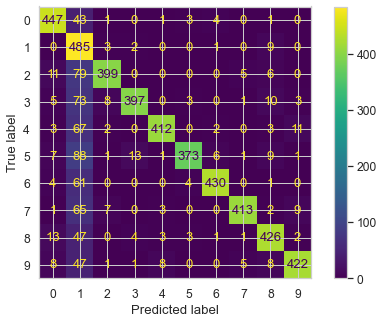

In [184]:
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
cmd.plot();

In [185]:
print(f'--> Bayes Search 3: test set accuracy_score = {round(accuracy_score(y_test, y_test_bayes3_search_pred),4)}')

#--> LinearSVM: test set accuracy_score = 0.8732
#--> SVM(kernel=rbf): test set accuracy_score = 0.9536
#--> Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
#--> Bayes search: test set accuracy_score = 0.9552 --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])
#--> Bayes Search 2: test set accuracy_score = 0.9544 --> Bayes search 2 best result: using OrderedDict([('activation', 'relu'), ('solver', 'adam')])

#--> Bayes Search 3: test set accuracy_score = 0.8408 --> Bayes search 3 best result: using OrderedDict([('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly'))])

--> Bayes Search 3: test set accuracy_score = 0.8408


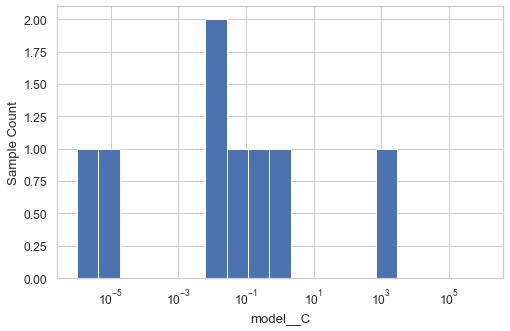

In [186]:
_ = plot_histogram(bayes_opt3.optimizer_results_[0], 1)
plt.show()

### 7. Final Results:

- **2. SVM Model Training using two different Kernels:**
  - LinearSVM: test set accuracy_score = 0.8732
  - SVM(kernel=rbf): test set accuracy_score = 0.9536

- **3. Hyper-parameter search by using cross-validation:**
  - Grid Search: test set accuracy_score = 0.9588  --> Grid search best result: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
  - Bayes Search: test set accuracy_score = 0.9552  --> Bayes search best result: using OrderedDict([('C', 44.768273074030795), ('degree', 2), ('gamma', 0.7263010462077173), ('kernel', 'poly')])

- **4. MLP Model Training:**
  - MLP: test set accuracy_score = 0.9504
  
- **5. Hyper-parameter search by using cross-validation**
  - Bayes Search 2: test set accuracy_score = 0.9544  --> Bayes search 2 best result: using OrderedDict([('activation', 'relu'), ('solver', 'adam')])

- **6. Evaluating different ML model families with Sklearn BayesSearchCV and Pipes: a more comprehensive example**
  - Bayes Search 3: test set accuracy_score = 0.8408  --> Bayes search 3 best result: [('model', SVC(C=735.4496833294961, degree=7, gamma=0.006630670566664593, kernel='poly'))]